In [1]:
library(Seurat)
library(ggplot2)
library(cowplot)
library(dplyr)
library(future)
library(stringr)
library(rstatix)
library(scRepertoire)
library(Trex)
library(circlize)
library(patchwork)
library(ggrepel)
library(tibble)
library(ggpubr)
library(tidydr)
library(corrplot)
library(reshape2)
library(ComplexHeatmap)
library(RColorBrewer)
library(randomcoloR)
options(jupyter.plot_scale=1, repr.matrix.max.cols=200)
`%nin%` = Negate(`%in%`)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    a

In [2]:
tc_tcr <- readRDS('data/b16_tc_tcr_5batch.rds')
# IEDB full TCR data
iedb <- read.csv('csv/tcrmatch/tcr_full_v3.csv', skip=1)
# TCRMatch output for all expanded TCRs
tcrmatch_expanded <- read.csv('csv/tcrmatch/tcrmatch_result_expanded.tsv', sep='\t')

In [3]:
# If a TCR has multiple antigens, use the source organism with highest frequency
mode <- function(x) names(sort(-table(x)))[1]
tcrmatch_expanded$organism_mode <- unlist(lapply(str_split(tcrmatch_expanded$organism,','), mode))
dim(tcrmatch_expanded)

[1] 162574      8

In [4]:
# Select top 5 expanded TCR from each sample
top_tcr <- tc_tcr@meta.data  %>% distinct(sample, CTaa, .keep_all = TRUE) %>% group_by(sample)%>% 
    arrange(desc(clonalFrequency)) %>% slice_head(n=5) %>% select(orig.ident, CDsubset, CTaa, CTgene, clonalFrequency) %>% 
    mutate(va=str_extract(CTgene, '([^.+]*)'), cdr3a=str_extract(CTaa, '([^_]*)'), 
           vb=str_extract(CTgene, '(?<=_)([^.+]*)'), cdr3b=str_extract(CTaa, '(?<=_)([^_]*)'))
dim(top_tcr)

Adding missing grouping variables: `sample`


[1] 100  10

In [5]:
top_cdr3b_trimmed <- str_sub(unlist(str_split(top_tcr$cdr3b,';')),2,-2)
top_cdr3b_trimmed <- top_cdr3b_trimmed[str_length(top_cdr3b_trimmed)>0]
tcrmatch_expanded %>% filter(trimmed_input_sequence %in% top_cdr3b_trimmed & organism_mode !='') %>% write.csv('csv/tcrmatch_result_top_expanded.csv')

In [6]:
# Compare the frequency of source organisms in full IEDB database and TCRMatch query output
iedb_org_freq <- iedb %>% filter(CDR3.Curated.1!='' & Source.Organism !='') %>% group_by(Source.Organism) %>% summarize(count=n()) %>% 
    arrange(desc(count)) %>% mutate(pct=count/sum(count)) %>% rename(organism=Source.Organism)

query_org_freq <- tcrmatch_expanded %>% filter(trimmed_input_sequence %in% top_cdr3b_trimmed & organism_mode !='') %>% 
    group_by(trimmed_input_sequence) %>% slice_max(order_by=score, n=10, with_ties=T) %>% 
    group_by(organism_mode) %>%  summarize(count=n()) %>% 
    arrange(desc(count)) %>% mutate(pct=count/sum(count)) %>% rename(organism=organism_mode)
merged_freq <- merge(query_org_freq, iedb_org_freq, by='organism', all=T) 
merged_freq[is.na(merged_freq)] <- 0
merged_freq_filtered <- merged_freq %>% filter(count.x>3) 
organism_short_name <- merged_freq_filtered$organism %>% str_replace('\\(.*\\)','')
organism_short_name[9:10] <- c('Influenza A virus (A/Puerto Rico/8/1934(H1N1))','Influenza A virus (A/Puerto Rico/8/34/Mount Sinai(H1N1))')
merged_freq_filtered$organism <- organism_short_name
merged_freq_fisher <- cbind(merged_freq_filtered, merged_freq_filtered %>% select(count.x, count.y) %>% row_wise_fisher_test() )
org_order <- merged_freq_filtered %>% mutate(fc=(pct.x+1e-5)/(pct.y+1e-5)) %>% arrange(desc(fc)) %>% pull(organism)

Using organism as id variables



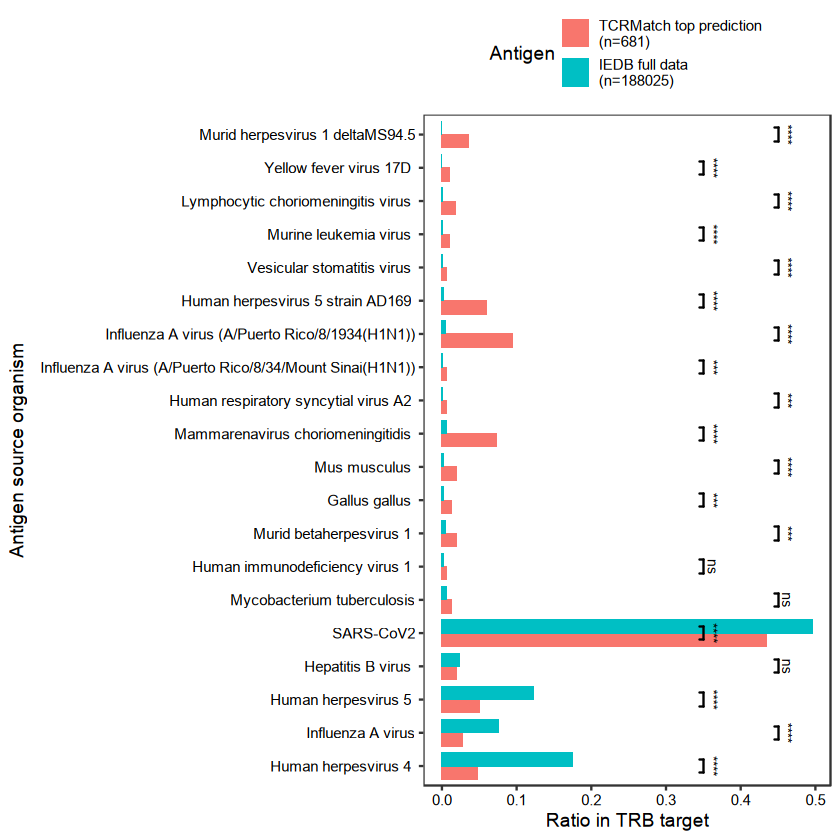

In [7]:
merged_pct <- merged_freq_filtered %>% melt() %>% filter(str_detect(variable, 'pct') ) %>% 
    mutate(antigen=recode(variable, 'pct.x'=paste0('TCRMatch top prediction\n(n=',sum(merged_freq$count.x),')'), 
                          'pct.y'=paste0('IEDB full data\n(n=',sum(merged_freq$count.y),')')),
          organism=factor(organism, levels=rev(org_order)))
sig_annotations <- rev(merged_freq_fisher[match(org_order, merged_freq_fisher$organism),'p.adj.signif'])
ggplot(merged_pct, aes(y=value, x=organism, fill=antigen)) + geom_col(position='dodge', width=0.8)+ 
    geom_signif(y_position = 0.45-0.1*(1:length(sig_annotations) %% 2), xmin = 1:length(sig_annotations)-0.2, xmax = 1:length(sig_annotations)+0.2, 
                textsize=2.8, annotation = sig_annotations, tip_length = 0.01) + 
    labs(y='Ratio in TRB target', x='Antigen source organism', fill='Antigen') +
    guides(fill=guide_legend(nrow=2)) +
    theme_bw() + theme(legend.position='top', axis.text=element_text(color='black'))   + coord_flip() +
    theme(panel.grid=element_blank())
ggsave('plot/b16_tcrmatch_organism_overrepresentation.pdf', width=5, height=5, device=pdf)

In [8]:
enriched_organism <- merged_freq %>% mutate(fc=pct.x/pct.y) %>% filter(fc>2) %>% pull(organism)
enriched_organism_short <- enriched_organism %>% str_replace('\\(.*\\)','')
enriched_organism_short[c(1,9:11)] <- c('AKR murine leukemia virus',
                              'Influenza A virus (A/Luxembourg/46/2009(H1N1))',
                              'Influenza A virus (A/Puerto Rico/8/1934(H1N1))',
                              'Influenza A virus (A/Puerto Rico/8/34/Mount Sinai(H1N1))')
names(enriched_organism_short) <- enriched_organism

iedb_best_pred <-  tcrmatch_expanded %>% filter(organism %in% enriched_organism) %>% 
    group_by(trimmed_input_sequence) %>% slice_max(order_by=score, n=1, with_ties=F) %>% mutate(organism_short=enriched_organism_short[organism])
tc_tcr$antigen_organism <- NA
for(i in 1:nrow(iedb_best_pred))
{
    tc_tcr$antigen_organism[str_detect(tc_tcr$CTaa, iedb_best_pred$trimmed_input_sequence[i])] <- iedb_best_pred$organism_short[i]
}
tc_tcr$antigen_organism[tc_tcr$specificity=='specific'] <- NA

`summarise()` has grouped output by 'antigen_organism'. You can override using the `.groups` argument.
Using count as value column: use value.var to override.



pdf 
  2

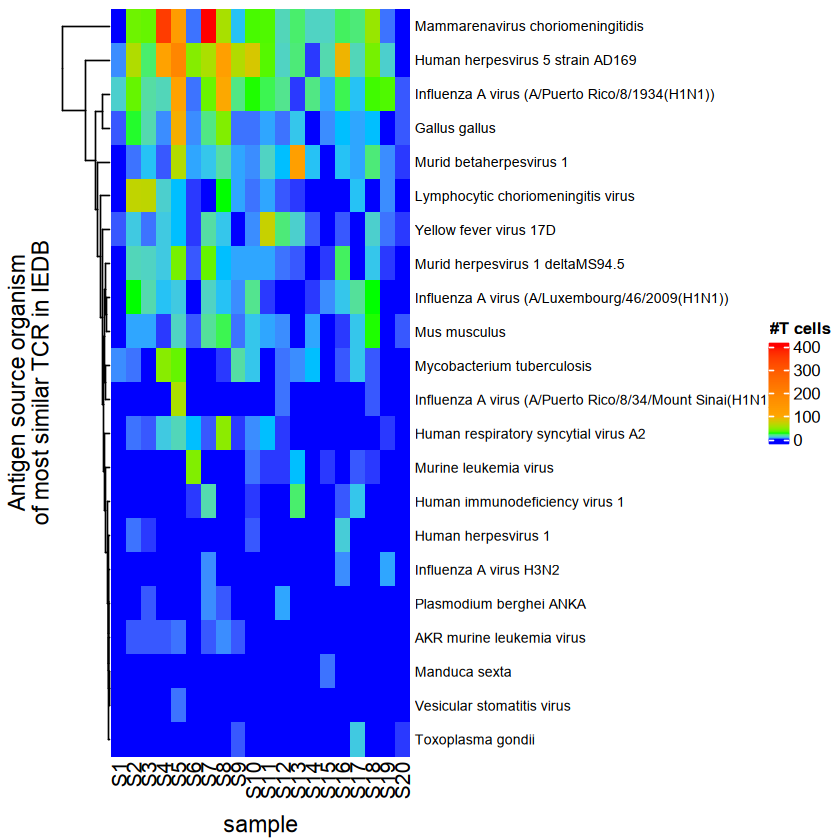

In [9]:
count_antigen_smaple <- tc_tcr@meta.data %>% filter(!is.na(antigen_organism)) %>% group_by(antigen_organism, sample) %>% 
    summarize(count=n()) %>% dcast(antigen_organism ~ sample) %>% column_to_rownames('antigen_organism')
count_antigen_smaple[is.na(count_antigen_smaple)] <- 0
pdf('plot/b16_heatmap_antigen_source_organism.pdf', width=7.5, height=4)
ht <- Heatmap(as.matrix(count_antigen_smaple), col = colorRamp2(c(0,6,25,100,400),c('blue','deepskyblue','green','orange','red')), 
              row_title = 'Antigen source organism\nof most similar TCR in IEDB', row_title_side = c("left"),
              column_title = 'sample',column_title_side = c("bottom"),
              cluster_columns=F, name='#T cells', row_names_gp = gpar(fontsize = 8),
              row_names_max_width = max_text_width(rownames(count_antigen_smaple), gp = gpar(fontsize = 8)
    ))
ht
dev.off()
ht

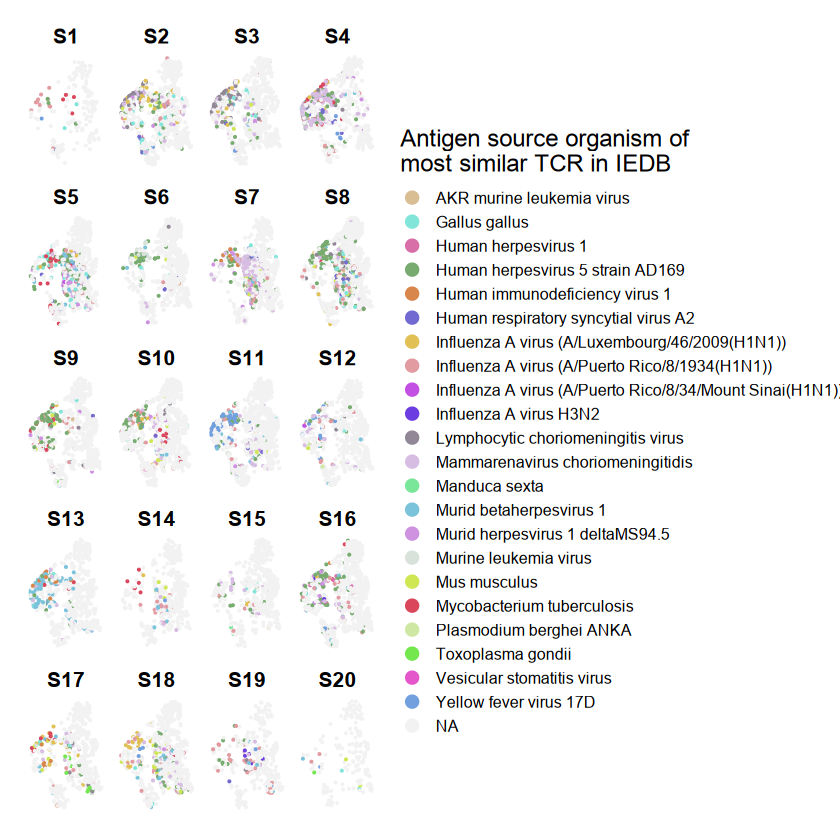

In [10]:
DimPlot(tc_tcr, group.by='antigen_organism', split.by='sample', ncol=4) + NoAxes() + 
    theme(legend.text=element_text(size=9), legend.key.size=unit(0.2,'in'), plot.title=element_blank()) +
    scale_color_manual(values=distinctColorPalette(22), na.value='gray95', name='Antigen source organism of\nmost similar TCR in IEDB') +
    guides(color=guide_legend(ncol=1, override.aes = list(size=3)))
ggsave('plot/b16_umap_antigen_source_organism.pdf', width=11, height=8, device=pdf)